# Cross RMSD

In [5]:
import mdtraj as md
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd


# TRAIN-MD

In [6]:
def load_align_select(xtc_file, pdb_file):
    traj = md.load_xtc(xtc_file, top=pdb_file)
    ref  = md.load_pdb(pdb_file)
    return traj, ref

def split_trajectory_for_rmsd(
    traj,
    discard_frames=150,
    train_fraction=0.4,
    val_fraction=0.1,
    shuffle_learn=True,
    seed=None

):
    np.random.seed(seed)

    traj_use = traj[discard_frames:]
    n_use = traj_use.n_frames

    n_learn = int(train_fraction * n_use)
    traj_learn = traj_use[:n_learn]

    if shuffle_learn:
        perm = np.random.permutation(traj_learn.n_frames)
        traj_learn = traj_learn[perm]

    n_train = int((1 - val_fraction) * traj_learn.n_frames)
    traj_train = traj_learn[:n_train]

    return traj_train

def compute_cross_rmsd(train_traj, gen_traj):
    rmsd_matrix = np.zeros((train_traj.n_frames, gen_traj.n_frames))

    for i in range(train_traj.n_frames):
        rmsd_matrix[i, :] = md.rmsd(
            gen_traj,
            train_traj[i]
        )

    return rmsd_matrix
def plot_cross_rmsd_heatmap(
    rmsd_matrix,
    title,
    savepath,
    vmax = 0.4

):
    plt.figure(figsize=(10, 6))

    im = plt.imshow(
        rmsd_matrix,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmax=vmax
    )

    plt.colorbar(im, label="RMSD (Å)")
    plt.xlabel("Generated conformations")
    plt.ylabel("Training conformations")
    plt.title(title)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.close()


In [7]:
proteins  = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas  = [0, 1, 2]

frac = 0.4
frac_tag = int(frac * 100)

discard_frames = 150
val_fraction   = 0.1
shuffle_learn  = True

base_md_dir   = "../../data/palantir_data"
base_gen_dir  = "../shuffle_not_allframes"
out_base_dir  = "../cross_rmsd"

os.makedirs(out_base_dir, exist_ok=True)

for protein in proteins:
    for rep in replicas:
        
        print(f"[INFO] {protein} | frac={frac} | rep={rep}")

        md_xtc = f"{base_md_dir}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        gen_xtc = f"{base_gen_dir}/{protein}/{protein}_rep_{rep}/fraction_{frac_tag}/generated_frac_{frac_tag}.xtc"
        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"
        out_dir = f"{out_base_dir}/{protein}/fraction_{frac_tag}/rep_{rep}"
        os.makedirs(out_dir, exist_ok=True)

        # Load + preprocess train traj
        traj, ref = load_align_select(md_xtc, pdb_file)

        traj_train = split_trajectory_for_rmsd(
            traj,
            discard_frames=discard_frames,
            train_fraction=frac,
            val_fraction=val_fraction,
                    )

        # Load generated traj 
        gen_traj = md.load_xtc(gen_xtc, top=pdb_file)

        # Cross RMSD
        rmsd_matrix = compute_cross_rmsd(traj_train, gen_traj)

        np.save(f"{out_dir}/cross_rmsd.npy", rmsd_matrix)

        # Plot
        plot_cross_rmsd_heatmap(
            rmsd_matrix,
            title=f"{protein} | frac={frac} | rep={rep}",
            savepath=f"{out_dir}/cross_rmsd_heatmap.png"
        )


[INFO] 3UTQ | frac=0.4 | rep=0
[INFO] 3UTQ | frac=0.4 | rep=1
[INFO] 3UTQ | frac=0.4 | rep=2
[INFO] 5N1Y | frac=0.4 | rep=0
[INFO] 5N1Y | frac=0.4 | rep=1
[INFO] 5N1Y | frac=0.4 | rep=2
[INFO] 5C0F | frac=0.4 | rep=0
[INFO] 5C0F | frac=0.4 | rep=1
[INFO] 5C0F | frac=0.4 | rep=2
[INFO] pep_free | frac=0.4 | rep=0
[INFO] pep_free | frac=0.4 | rep=1
[INFO] pep_free | frac=0.4 | rep=2


# MD-MD Cross RMSD

In [10]:
proteins  = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas  = [0, 1, 2]

def plot_cross_rmsd_heatmap_Md(
    rmsd_matrix,
    title,
    savepath,
    vmax = 0.4

):
    plt.figure(figsize=(10, 6))

    im = plt.imshow(
        rmsd_matrix,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmax=vmax
    )

    plt.colorbar(im, label="RMSD (Å)")
    plt.xlabel("MD conformations")
    plt.ylabel("MD conformations")
    plt.title(title)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.close()


base_md_dir   = "../../data/palantir_data"
out_base_dir  = "../cross_rmsd"

os.makedirs(out_base_dir, exist_ok=True)

for protein in proteins:
    for rep in replicas:
        
        print(f"[INFO] {protein} | rep={rep}")

        md_xtc = f"{base_md_dir}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"
        out_dir = f"{out_base_dir}/{protein}/md/rep_{rep}"
        os.makedirs(out_dir, exist_ok=True)

        MD_traj = md.load_xtc(md_xtc, top=pdb_file)

        # Cross RMSD
        rmsd_matrix = compute_cross_rmsd(MD_traj, MD_traj)

        np.save(f"{out_dir}/cross_rmsd.npy", rmsd_matrix)

        # Plot
        plot_cross_rmsd_heatmap_Md(
            rmsd_matrix,
            title=f"{protein}| rep={rep}",
            savepath=f"{out_dir}/cross_rmsd_heatmap.png"
        )


[INFO] 3UTQ | rep=0
[INFO] 3UTQ | rep=1
[INFO] 3UTQ | rep=2
[INFO] 5N1Y | rep=0
[INFO] 5N1Y | rep=1
[INFO] 5N1Y | rep=2
[INFO] 5C0F | rep=0
[INFO] 5C0F | rep=1
[INFO] 5C0F | rep=2
[INFO] pep_free | rep=0
[INFO] pep_free | rep=1
[INFO] pep_free | rep=2


# MD-GEN

In [12]:
proteins  = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas  = [0, 1, 2]

base_md_dir   = "../../data/palantir_data"
base_gen_dir  = "../shuffle_not_allframes"
out_base_dir  = "../cross_rmsd"
frac = 0.4
frac_tag = int(frac * 100)
os.makedirs(out_base_dir, exist_ok=True)
def plot_cross_rmsd_heatmap_Md_GEN(
    rmsd_matrix,
    title,
    savepath,
    vmax = 0.4

):
    plt.figure(figsize=(10, 6))

    im = plt.imshow(
        rmsd_matrix,
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmax=vmax
    )

    plt.colorbar(im, label="RMSD (Å)")
    plt.xlabel("GEN conformations")
    plt.ylabel("MD conformations")
    plt.title(title)

    plt.tight_layout()
    plt.savefig(savepath, dpi=300)
    plt.close()
for protein in proteins:
    for rep in replicas:
        
        print(f"[INFO] {protein} | rep={rep}")

        md_xtc = f"{base_md_dir}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        gen_xtc = f"{base_gen_dir}/{protein}/{protein}_rep_{rep}/fraction_{frac_tag}/generated_frac_{frac_tag}.xtc"
        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"
        out_dir = f"{out_base_dir}/{protein}/Md_gen/rep_{rep}"
        os.makedirs(out_dir, exist_ok=True)

        # Load generated traj 
        gen_traj = md.load_xtc(gen_xtc, top=pdb_file)
        md_traj = md.load_xtc(md_xtc, top=pdb_file)

        # Cross RMSD
        rmsd_matrix = compute_cross_rmsd(gen_traj, md_traj)

        np.save(f"{out_dir}/cross_rmsd.npy", rmsd_matrix)

        # Plot
        plot_cross_rmsd_heatmap_Md_GEN(
            rmsd_matrix,
            title=f"{protein} | frac={frac} | rep={rep}",
            savepath=f"{out_dir}/cross_rmsd_heatmap.png"
        )


[INFO] 3UTQ | rep=0
[INFO] 3UTQ | rep=1
[INFO] 3UTQ | rep=2
[INFO] 5N1Y | rep=0
[INFO] 5N1Y | rep=1
[INFO] 5N1Y | rep=2
[INFO] 5C0F | rep=0
[INFO] 5C0F | rep=1
[INFO] 5C0F | rep=2
[INFO] pep_free | rep=0
[INFO] pep_free | rep=1
[INFO] pep_free | rep=2


# min crossRMSD


In [8]:
def compute_min_rmsd_per_generated(rmsd_matrix):
    return np.min(rmsd_matrix, axis=0)
def plot_min_rmsd_distribution(
    min_rmsd,
    bins=50,
    title="Minimum RMSD to Training Set",
    savepath=None
):
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.hist(min_rmsd, bins=bins, density=True, alpha=0.75)
    ax.set_xlabel("Minimum RMSD (Å)")
    ax.set_ylabel("Density")
    ax.set_title(title)

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.close()


In [9]:
base_dir = "../cross_rmsd"

frac = 0.4
frac_tag = int(frac * 100)

summary_rows = []

for protein in proteins:
    for rep in replicas:

        rmsd_path = (
            f"{base_dir}/{protein}/fraction_{frac_tag}/rep_{rep}/cross_rmsd.npy"
        )

        if not os.path.exists(rmsd_path):
            print(f"[WARN] Missing: {rmsd_path}")
            continue

        print(f"[INFO] Processing {protein} | frac={frac} | rep={rep}")

        rmsd_matrix = np.load(rmsd_path)
        min_rmsd = compute_min_rmsd_per_generated(rmsd_matrix)

        # ---- plot histogram ----
        out_plot = (
            f"{base_dir}/{protein}/fraction_{frac_tag}/rep_{rep}/"
            f"min_rmsd_hist.png"
        )

        plot_min_rmsd_distribution(
            min_rmsd,
            title=f"{protein} | frac={frac} | rep={rep}",
            savepath=out_plot
        )

        # ---- collect statistics ----
        summary_rows.append({
            "protein ID": protein,
            "replica": rep,
            "min_Cross_rmsd_mean": np.mean(min_rmsd),
            "min_Cross_rmsd_std": np.std(min_rmsd),
        })


[INFO] Processing 3UTQ | frac=0.4 | rep=0
[INFO] Processing 3UTQ | frac=0.4 | rep=1
[INFO] Processing 3UTQ | frac=0.4 | rep=2
[INFO] Processing 5N1Y | frac=0.4 | rep=0
[INFO] Processing 5N1Y | frac=0.4 | rep=1
[INFO] Processing 5N1Y | frac=0.4 | rep=2
[INFO] Processing 5C0F | frac=0.4 | rep=0
[INFO] Processing 5C0F | frac=0.4 | rep=1
[INFO] Processing 5C0F | frac=0.4 | rep=2
[INFO] Processing pep_free | frac=0.4 | rep=0
[INFO] Processing pep_free | frac=0.4 | rep=1
[INFO] Processing pep_free | frac=0.4 | rep=2


# MD-MD

In [11]:
base_dir = "../cross_rmsd"

summary_rows = []

for protein in proteins:
    for rep in replicas:

        rmsd_path = (
            f"{base_dir}/{protein}/md/rep_{rep}/cross_rmsd.npy"
        )

        if not os.path.exists(rmsd_path):
            print(f"[WARN] Missing: {rmsd_path}")
            continue

        print(f"[INFO] Processing {protein} | rep={rep}")

        rmsd_matrix = np.load(rmsd_path)
        min_rmsd = compute_min_rmsd_per_generated(rmsd_matrix)

        # ---- plot histogram ----
        out_plot = (
            f"{base_dir}/{protein}/md/rep_{rep}/"
            f"min_rmsd_hist.png"
        )

        plot_min_rmsd_distribution(
            min_rmsd,
            title=f"{protein}| rep={rep}",
            savepath=out_plot
        )

        # ---- collect statistics ----
        summary_rows.append({
            "protein ID": protein,
            "replica": rep,
            "min_Cross_rmsd_mean": np.mean(min_rmsd),
            "min_Cross_rmsd_std": np.std(min_rmsd),
        })


[INFO] Processing 3UTQ | rep=0
[INFO] Processing 3UTQ | rep=1
[INFO] Processing 3UTQ | rep=2
[INFO] Processing 5N1Y | rep=0
[INFO] Processing 5N1Y | rep=1
[INFO] Processing 5N1Y | rep=2
[INFO] Processing 5C0F | rep=0
[INFO] Processing 5C0F | rep=1
[INFO] Processing 5C0F | rep=2
[INFO] Processing pep_free | rep=0
[INFO] Processing pep_free | rep=1
[INFO] Processing pep_free | rep=2


# Md-GEN

In [13]:
base_dir = "../cross_rmsd"

summary_rows = []

for protein in proteins:
    for rep in replicas:

        rmsd_path = (
            f"{base_dir}/{protein}/Md_gen/rep_{rep}/cross_rmsd.npy"
        )

        if not os.path.exists(rmsd_path):
            print(f"[WARN] Missing: {rmsd_path}")
            continue

        print(f"[INFO] Processing {protein} | rep={rep}")

        rmsd_matrix = np.load(rmsd_path)
        min_rmsd = compute_min_rmsd_per_generated(rmsd_matrix)

        # ---- plot histogram ----
        out_plot = (
            f"{base_dir}/{protein}/Md_gen/rep_{rep}/"
            f"min_rmsd_hist.png"
        )

        plot_min_rmsd_distribution(
            min_rmsd,
            title=f"{protein}| rep={rep}",
            savepath=out_plot
        )

        # ---- collect statistics ----
        summary_rows.append({
            "protein ID": protein,
            "replica": rep,
            "min_Cross_rmsd_mean": np.mean(min_rmsd),
            "min_Cross_rmsd_std": np.std(min_rmsd),
        })


[INFO] Processing 3UTQ | rep=0
[INFO] Processing 3UTQ | rep=1
[INFO] Processing 3UTQ | rep=2
[INFO] Processing 5N1Y | rep=0
[INFO] Processing 5N1Y | rep=1
[INFO] Processing 5N1Y | rep=2
[INFO] Processing 5C0F | rep=0
[INFO] Processing 5C0F | rep=1
[INFO] Processing 5C0F | rep=2
[INFO] Processing pep_free | rep=0
[INFO] Processing pep_free | rep=1
[INFO] Processing pep_free | rep=2


In [105]:
df_summary = pd.DataFrame(summary_rows)

df_summary.to_csv(
    f"{base_dir}/min_rmsd_summary.csv",
    index=False
)

print(df_summary)

   protein ID  replica  min_Cross_rmsd_mean  min_Cross_rmsd_std
0        3UTQ        0             0.087229            0.008927
1        3UTQ        1             0.094119            0.010639
2        3UTQ        2             0.096233            0.012113
3        5N1Y        0             0.095337            0.011424
4        5N1Y        1             0.085127            0.008908
5        5N1Y        2             0.082388            0.007208
6        5C0F        0             0.090539            0.009495
7        5C0F        1             0.085631            0.009118
8        5C0F        2             0.110636            0.014284
9    pep_free        0             0.099095            0.013009
10   pep_free        1             0.105365            0.013796
11   pep_free        2             0.102328            0.012337


In [116]:
df_table = (
    df_summary
    .groupby("protein ID")[["min_Cross_rmsd_mean", "min_Cross_rmsd_std"]]
    .mean()
    .reset_index()
)

In [117]:
df_table

,protein ID,min_Cross_rmsd_mean,min_Cross_rmsd_std
0,3UTQ,0.092527,0.010560
1,5C0F,0.095602,0.010966
2,5N1Y,0.087617,0.009180
3,pep_free,0.102263,0.013047


# MD RMSD

In [118]:
def compute_md_rmsd_single_replica(
    xtc_file,
    pdb_file
):
    """
    Compute MD RMSD (Å) relative to the mean structure
    for a single MD replica.
    """

    traj = md.load_xtc(xtc_file, top=pdb_file)

    # Mean structure
    mean_xyz = traj.xyz.mean(axis=0, keepdims=True)
    mean_traj = md.Trajectory(mean_xyz, traj.topology)

    # RMSD (mdtraj gives nm)
    rmsd_nm = md.rmsd(traj, mean_traj)
    rmsd_A  = rmsd_nm * 10.0

    return rmsd_A.mean(), rmsd_A.std()

In [119]:
proteins = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas = [0, 1, 2]

base_md_dir = "../../data/palantir_data"

md_rmsd_rows = []

for protein in proteins:
    for rep in replicas:

        xtc_file = f"{base_md_dir}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"

        if not os.path.exists(xtc_file):
            print(f"[WARN] Missing XTC: {xtc_file}")
            continue

        print(f"[INFO] MD RMSD | {protein} | rep={rep}")

        mean_rmsd, std_rmsd = compute_md_rmsd_single_replica(
            xtc_file,
            pdb_file
        )

        md_rmsd_rows.append({
            "protein ID": protein,
            "replica": rep,
            "md_rmsd_mean_A": mean_rmsd,
            "md_rmsd_std_A": std_rmsd

        })


[INFO] MD RMSD | 3UTQ | rep=0
[INFO] MD RMSD | 3UTQ | rep=1
[INFO] MD RMSD | 3UTQ | rep=2
[INFO] MD RMSD | 5N1Y | rep=0
[INFO] MD RMSD | 5N1Y | rep=1
[INFO] MD RMSD | 5N1Y | rep=2
[INFO] MD RMSD | 5C0F | rep=0
[INFO] MD RMSD | 5C0F | rep=1
[INFO] MD RMSD | 5C0F | rep=2
[INFO] MD RMSD | pep_free | rep=0
[INFO] MD RMSD | pep_free | rep=1
[INFO] MD RMSD | pep_free | rep=2


In [120]:
df_md_rep = pd.DataFrame(md_rmsd_rows)

df_md_avg = (
    df_md_rep
    .groupby("protein ID")
    .agg(
        md_rmsd_mean_A=("md_rmsd_mean_A", "mean"),
        md_rmsd_std_A=("md_rmsd_mean_A", "std")
    )
    .reset_index()
)

print(df_md_avg)


  protein ID  md_rmsd_mean_A  md_rmsd_std_A
0       3UTQ        1.531637       0.190295
1       5C0F        1.523946       0.116380
2       5N1Y        1.396138       0.130387
3   pep_free        1.567743       0.092449


In [121]:
df_md_avg

,protein ID,md_rmsd_mean_A,md_rmsd_std_A
0,3UTQ,1.531637,0.190295
1,5C0F,1.523946,0.116380
2,5N1Y,1.396138,0.130387
3,pep_free,1.567743,0.092449


# Test RMSD

In [122]:
import mdtraj as md
import numpy as np

def compute_test_reconstruction_rmsd(
    test_xtc,
    recon_xtc,
    pdb_file
):
    test_traj  = md.load_xtc(test_xtc, top=pdb_file)
    recon_traj = md.load_xtc(recon_xtc, top=pdb_file)

    assert test_traj.n_frames == recon_traj.n_frames, \
        "Frame sayıları eşleşmiyor!"

    rmsd_nm = md.rmsd(recon_traj, test_traj)
    rmsd_A  = rmsd_nm * 10.0

    return rmsd_A.mean(), rmsd_A.std()


In [123]:
import pandas as pd
import os

proteins  = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas  = [0, 1, 2]


frac = 0.4
frac_tag = int(frac * 100)

base_md_dir   = "../../data/palantir_data"
base_out_dir  = "../shuffle_not_allframes"

rows = []

for protein in proteins:
    for rep in replicas:

        print(f"[INFO] Reconstruction RMSD | {protein} | frac={frac} | rep={rep}")

        test_xtc = (
            f"{base_out_dir}/{protein}/{protein}_rep_{rep}/"
            f"fraction_{frac_tag}/md_test_subset.xtc"
        )

        recon_xtc = (
            f"{base_out_dir}/{protein}/{protein}_rep_{rep}/"
            f"fraction_{frac_tag}/reconstructed_test.xtc"
        )

        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"

        if not os.path.exists(recon_xtc):
            print("Missing:", recon_xtc)
            continue

        mean_rmsd, std_rmsd = compute_test_reconstruction_rmsd(
            test_xtc,
            recon_xtc,
            pdb_file
        )

        rows.append({
            "protein ID": protein,
            "replica": rep,
            "test_rmsd_mean_A": mean_rmsd,
            "test_rmsd_std_A": std_rmsd
        })


[INFO] Reconstruction RMSD | 3UTQ | frac=0.4 | rep=0
[INFO] Reconstruction RMSD | 3UTQ | frac=0.4 | rep=1
[INFO] Reconstruction RMSD | 3UTQ | frac=0.4 | rep=2
[INFO] Reconstruction RMSD | 5N1Y | frac=0.4 | rep=0
[INFO] Reconstruction RMSD | 5N1Y | frac=0.4 | rep=1
[INFO] Reconstruction RMSD | 5N1Y | frac=0.4 | rep=2
[INFO] Reconstruction RMSD | 5C0F | frac=0.4 | rep=0
[INFO] Reconstruction RMSD | 5C0F | frac=0.4 | rep=1
[INFO] Reconstruction RMSD | 5C0F | frac=0.4 | rep=2
[INFO] Reconstruction RMSD | pep_free | frac=0.4 | rep=0
[INFO] Reconstruction RMSD | pep_free | frac=0.4 | rep=1
[INFO] Reconstruction RMSD | pep_free | frac=0.4 | rep=2


In [124]:
df_test = pd.DataFrame(rows)

df_test_avg = (
    df_test
    .groupby(["protein ID"])
    .agg(
        test_rmsd_mean_A=("test_rmsd_mean_A", "mean"),
        test_rmsd_std_A=("test_rmsd_mean_A", "std")
    )
    .reset_index()
)

print(df_test_avg)

  protein ID  test_rmsd_mean_A  test_rmsd_std_A
0       3UTQ          1.793694         0.295960
1       5C0F          1.946230         0.574470
2       5N1Y          1.394286         0.148855
3   pep_free          2.084755         0.461135


In [125]:
df_test_avg

,protein ID,test_rmsd_mean_A,test_rmsd_std_A
0,3UTQ,1.793694,0.295960
1,5C0F,1.946230,0.574470
2,5N1Y,1.394286,0.148855
3,pep_free,2.084755,0.461135


# VAE RMSD

In [127]:
import mdtraj as md
import numpy as np
import os
import pandas as pd

proteins = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas = [0, 1, 2]

frac = 0.4
frac_tag = int(frac * 100)

base_gen_dir = "../shuffle_not_allframes"
base_md_dir  = "../../data/palantir_data"

rows = []

def compute_generated_rmsd(gen_xtc, pdb_file):
    gen_traj = md.load_xtc(gen_xtc, top=pdb_file)

    # İlk frame referans
    rmsd_nm = md.rmsd(gen_traj, gen_traj[0])
    rmsd_A = rmsd_nm * 10.0

    return rmsd_A.mean(), rmsd_A.std()


for protein in proteins:
    for rep in replicas:

        gen_xtc = (
            f"{base_gen_dir}/{protein}/"
            f"{protein}_rep_{rep}/fraction_{frac_tag}/"
            f"generated_frac_{frac_tag}.xtc"
        )

        pdb_file = f"{base_md_dir}/{protein}/backbone.pdb"

        if not os.path.exists(gen_xtc):
            print(f"[WARN] Missing: {gen_xtc}")
            continue

        print(f"[INFO] {protein} | rep={rep} | frac=0.4")

        mean_rmsd, std_rmsd = compute_generated_rmsd(
            gen_xtc,
            pdb_file
        )

        rows.append({
            "protein ID": protein,
            "replica": rep,
            "VAE_rmsd_mean_A": mean_rmsd,
            "VAE_rmsd_std_A": std_rmsd
        })





[INFO] 3UTQ | rep=0 | frac=0.4
[INFO] 3UTQ | rep=1 | frac=0.4
[INFO] 3UTQ | rep=2 | frac=0.4
[INFO] 5N1Y | rep=0 | frac=0.4
[INFO] 5N1Y | rep=1 | frac=0.4
[INFO] 5N1Y | rep=2 | frac=0.4
[INFO] 5C0F | rep=0 | frac=0.4
[INFO] 5C0F | rep=1 | frac=0.4
[INFO] 5C0F | rep=2 | frac=0.4
[INFO] pep_free | rep=0 | frac=0.4
[INFO] pep_free | rep=1 | frac=0.4
[INFO] pep_free | rep=2 | frac=0.4


In [128]:
df_gen_04 = pd.DataFrame(rows)
print(df_gen_04)

   protein ID  replica  VAE_rmsd_mean_A  VAE_rmsd_std_A
0        3UTQ        0         1.343482        0.312902
1        3UTQ        1         1.973852        0.554773
2        3UTQ        2         1.598172        0.352521
3        5N1Y        0         1.690926        0.443218
4        5N1Y        1         1.401155        0.311038
5        5N1Y        2         1.009353        0.206963
6        5C0F        0         1.546824        0.444434
7        5C0F        1         1.220494        0.321640
8        5C0F        2         1.863832        0.407535
9    pep_free        0         1.494701        0.334590
10   pep_free        1         1.739294        0.377032
11   pep_free        2         1.608585        0.353727


In [132]:
df_VAE_avg = (
    df_gen_04
    .groupby(["protein ID"])
    .agg(
        VAE_rmsd_mean_A=("VAE_rmsd_mean_A", "mean"),
        VAE_rmsd_std_A=("VAE_rmsd_mean_A", "std")
    )
    .reset_index()
)

print(df_VAE_avg)

  protein ID  VAE_rmsd_mean_A  VAE_rmsd_std_A
0       3UTQ         1.638502        0.317114
1       5C0F         1.543717        0.321680
2       5N1Y         1.367145        0.342057
3   pep_free         1.614193        0.122393


# TABLO

In [133]:
import pandas as pd


frames_map = {
    "3UTQ": 876,
    "5C0F": 1001,
    "5N1Y": 875,
    "pep_free": 5001
}

df_merged = (
    df_test_avg
    .merge(df_md_avg, on="protein ID")
    .merge(df_table, on="protein ID")
    .merge(df_VAE_avg,on="protein ID")
)


df_merged["Frames"] = df_merged["protein ID"].map(frames_map)

df_merged["MD RMSD"] = (
    df_merged["md_rmsd_mean_A"].round(2).astype(str)
    + " ± "
    + df_merged["md_rmsd_std_A"].round(2).astype(str)
)

df_merged["VAE RMSD"] = (
    df_merged["VAE_rmsd_mean_A"].round(2).astype(str)
    + " ± "
    + df_merged["VAE_rmsd_std_A"].round(2).astype(str)
)


df_merged["Test RMSD"] = (
    df_merged["test_rmsd_mean_A"].round(2).astype(str)
    + " ± "
    + df_merged["test_rmsd_std_A"].round(2).astype(str)
)



df_merged["min CrossRMSD"] = (
    df_merged["min_Cross_rmsd_mean"].round(2).astype(str)
    + " ± "
    + df_merged["min_Cross_rmsd_std"].round(2).astype(str)
)


df_final = df_merged[
    ["protein ID", "Frames", "MD RMSD","VAE RMSD", "Test RMSD", "min CrossRMSD"]
]

df_final


,protein ID,Frames,MD RMSD,VAE RMSD,Test RMSD,min CrossRMSD
0,3UTQ,876,1.53 ± 0.19,1.64 ± 0.32,1.79 ± 0.3,0.09 ± 0.01
1,5C0F,1001,1.52 ± 0.12,1.54 ± 0.32,1.95 ± 0.57,0.1 ± 0.01
2,5N1Y,875,1.4 ± 0.13,1.37 ± 0.34,1.39 ± 0.15,0.09 ± 0.01
3,pep_free,5001,1.57 ± 0.09,1.61 ± 0.12,2.08 ± 0.46,0.1 ± 0.01


In [134]:
df_final.to_csv("rmsd_summary_table.csv", index=False)


# ESSA

In [ ]:
from prody import *
import numpy as np
import mdtraj as md
def processing_gen_test(
    traj,
    discard_frames=150,
    train_fraction=0.4,
    val_fraction=0.1,
    shuffle_learn=True,
    seed=None

):
    np.random.seed(seed)

    traj_use = traj[discard_frames:]
    n_use = traj_use.n_frames

    n_learn = int(train_fraction * n_use)
    traj_test = traj_use[n_learn:]


    return traj_test

def get_medoid_frame(traj):
    ca = traj.atom_slice(traj.topology.select("name CA"))
    n = ca.n_frames
    
    mean_rmsd = np.zeros(n)
    
    for i in range(n):
        rmsd_i = md.rmsd(ca, ca, i)
        mean_rmsd[i] = np.mean(rmsd_i)
    
    medoid_index = np.argmin(mean_rmsd)
    return medoid_index


def run_essa(pdb_file, n_modes=20, cutoff=15.0, gamma_scale=10.0):
    
    structure = parsePDB(pdb_file)
    calphas = structure.select('name CA')
    
    # --- Referans ANM ---
    anm_ref = ANM('Reference')
    anm_ref.buildHessian(calphas, cutoff=cutoff)
    anm_ref.calcModes(n_modes)
    
    ref_eigvals = anm_ref.getEigvals()
    
    n_res = calphas.numAtoms()
    essa_scores = np.zeros(n_res)
    
    # --- Her residue için perturbation ---
    for i in range(n_res):
        
        anm_pert = ANM('Perturbed')
        anm_pert.buildHessian(calphas, cutoff=cutoff)
        
  
        hessian = anm_pert.getHessian()
        
        idx = slice(3*i, 3*i+3)
        hessian[idx, idx] *= gamma_scale
        
        anm_pert.setHessian(hessian)
        anm_pert.calcModes(n_modes)
        
        pert_eigvals = anm_pert.getEigvals()
        
        # Low-frequency 
        delta = np.sum(np.abs(pert_eigvals - ref_eigvals))
        
        essa_scores[i] = delta
    
    return essa_scores
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))



In [ ]:
import os
import mdtraj as md
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from prody import *
import matplotlib.pyplot as plt

# ---------------------------
# SABİT PARAMETRELER
# ---------------------------

proteins = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
replicas = [0, 1, 2]
fraction_tag = "40"
train_fraction = 0.4
discard_frames = 150

base_md_dir = "../shuffle_not_allframes"
base_gen_dir = "../shuffle_not_allframes"
base_top_dir = "../../data/palantir_data"

main_output_dir = "ESSA_analysis"
os.makedirs(main_output_dir, exist_ok=True)

# ---------------------------
# LOOP
# ---------------------------

for protein in proteins:

    print(f"\n######## {protein} ########")

    protein_dir = os.path.join(main_output_dir, protein)
    os.makedirs(protein_dir, exist_ok=True)

    protein_results = []

    for rep in replicas:

        print(f"Processing Replica {rep}")

        rep_dir = os.path.join(protein_dir, f"rep{rep}")
        os.makedirs(rep_dir, exist_ok=True)

        # ---- Paths ----
        md_test_path = f"{base_md_dir}/{protein}/{protein}_rep_{rep}/fraction_{fraction_tag}/md_test_subset.xtc"
        gen_path = f"{base_gen_dir}/{protein}/{protein}_rep_{rep}/fraction_{fraction_tag}/generated_frac_{fraction_tag}.xtc"
        top = f"{base_top_dir}/{protein}/backbone.pdb"

        # ---- Load ----
        md_test = md.load(md_test_path, top=top)
        gen_full = md.load(gen_path, top=top)

        gen_test = processing_gen_test(
            gen_full,
            discard_frames=discard_frames,
            train_fraction=train_fraction,
            val_fraction=0.1,
            shuffle_learn=True,
            seed=None
        )

        # ---- Alignment ----
        ref = md.load(top)
        ca_indices = ref.topology.select("name CA")

        md_test.superpose(ref, atom_indices=ca_indices)
        gen_test.superpose(ref, atom_indices=ca_indices)

        # ---- Representative (Medoid) ----
        md_rep_idx = get_medoid_frame(md_test)
        gen_rep_idx = get_medoid_frame(gen_test)

        md_rep_pdb = os.path.join(rep_dir, "MD_rep.pdb")
        gen_rep_pdb = os.path.join(rep_dir, "GEN_rep.pdb")

        md_test[md_rep_idx].save(md_rep_pdb)
        gen_test[gen_rep_idx].save(gen_rep_pdb)

        # ---- ESSA ----
        essa_md = run_essa(md_rep_pdb)
        essa_gen = run_essa(gen_rep_pdb)

        # ---- Normalize ----
        essa_md_norm = normalize(essa_md)
        essa_gen_norm = normalize(essa_gen)

        # ---- Metrics ----
        pearson_corr, _ = pearsonr(essa_md_norm, essa_gen_norm)
        spearman_corr, _ = spearmanr(essa_md_norm, essa_gen_norm)

        k = int(0.1 * len(essa_md_norm))
        top_md = set(np.argsort(essa_md_norm)[-k:])
        top_gen = set(np.argsort(essa_gen_norm)[-k:])
        overlap = len(top_md & top_gen) / k


        plt.figure(figsize=(10,5))
        plt.plot(essa_md_norm, label="MD")
        plt.plot(essa_gen_norm, label="Generated")
        plt.xlabel("Residue Index")
        plt.ylabel("Normalized ESSA Score")
        plt.title(f"{protein} | Rep {rep}")
        plt.legend()
        plt.savefig(os.path.join(rep_dir, "ESSA_profile.png"), dpi=300)
        plt.close()

        # ---- Histogram ----
        plt.figure()
        plt.hist(essa_md_norm, bins=30, alpha=0.5, label="MD")
        plt.hist(essa_gen_norm, bins=30, alpha=0.5, label="Generated")
        plt.xlabel("Normalized ESSA Score")
        plt.ylabel("Count")
        plt.title(f"{protein} | Rep {rep}")
        plt.legend()
        plt.savefig(os.path.join(rep_dir, "ESSA_hist.png"), dpi=300)
        plt.close()

        protein_results.append({
            "Replica": rep,
            "Pearson": pearson_corr,
            "Spearman": spearman_corr,
            "Top10_Overlap": overlap
        })

  
    df_protein = pd.DataFrame(protein_results)
    df_protein.to_csv(os.path.join(protein_dir, f"{protein}_ESSA_metrics.csv"), index=False)

print("\nALL DONE.")



######## 3UTQ ########
Processing Replica 0


@> 1544 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.09s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.05s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.09s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.05s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 1


@> 1544 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 2


@> 1544 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.05s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc


######## 5N1Y ########
Processing Replica 0


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 1


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.05s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 2


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc


######## 5C0F ########
Processing Replica 0


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 1


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.09s.
@> Hessian was built in 0.05s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.09s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 2


@> 1548 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc


######## pep_free ########
Processing Replica 0


@> 1504 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.06s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.06s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 1


@> 1504 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.06s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.08s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc

Processing Replica 2


@> 1504 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.04s.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.06s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.06s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calculated.
@> 20 modes were calculated in 0.07s.
@> Hessian was built in 0.04s.
@> WARNING Fewer than 6 (3) zero eigenvalues were calc


ALL DONE.


In [7]:
import pandas as pd
import os

proteins = ["3UTQ", "5N1Y", "5C0F", "pep_free"]
base_dir = "ESSA_analysis"

all_data = []

for protein in proteins:
    csv_path = os.path.join(base_dir, protein, f"{protein}_ESSA_metrics.csv")
    df = pd.read_csv(csv_path)
    df["Protein"] = protein
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

print(df_all)


    Replica   Pearson  Spearman  Top10_Overlap   Protein
0         0  0.966683  0.950423       0.684211      3UTQ
1         1  0.975532  0.963346       0.763158      3UTQ
2         2  0.878495  0.914284       0.657895      3UTQ
3         0  0.966605  0.942710       0.631579      5N1Y
4         1  0.946179  0.945684       0.789474      5N1Y
5         2  0.973172  0.947261       0.684211      5N1Y
6         0  0.968900  0.949353       0.657895      5C0F
7         1  0.958437  0.943193       0.657895      5C0F
8         2  0.927073  0.952130       0.763158      5C0F
9         0  0.978990  0.968614       0.783784  pep_free
10        1  0.948955  0.948499       0.756757  pep_free
11        2  0.932725  0.944370       0.729730  pep_free


In [26]:
import pandas as pd

grouped = df_all.groupby("Protein")

summary_formatted = pd.DataFrame()

for metric in ["Pearson", "Spearman", "Top10_Overlap"]:
    
    mean = grouped[metric].mean()
    std = grouped[metric].std()
    
    summary_formatted[metric] = (
        mean.round(2).astype(str)
        + " ± " +
        std.round(2).astype(str)
    )

summary_formatted
summary_formatted.to_csv("ESSA_summary_mean_std.csv")


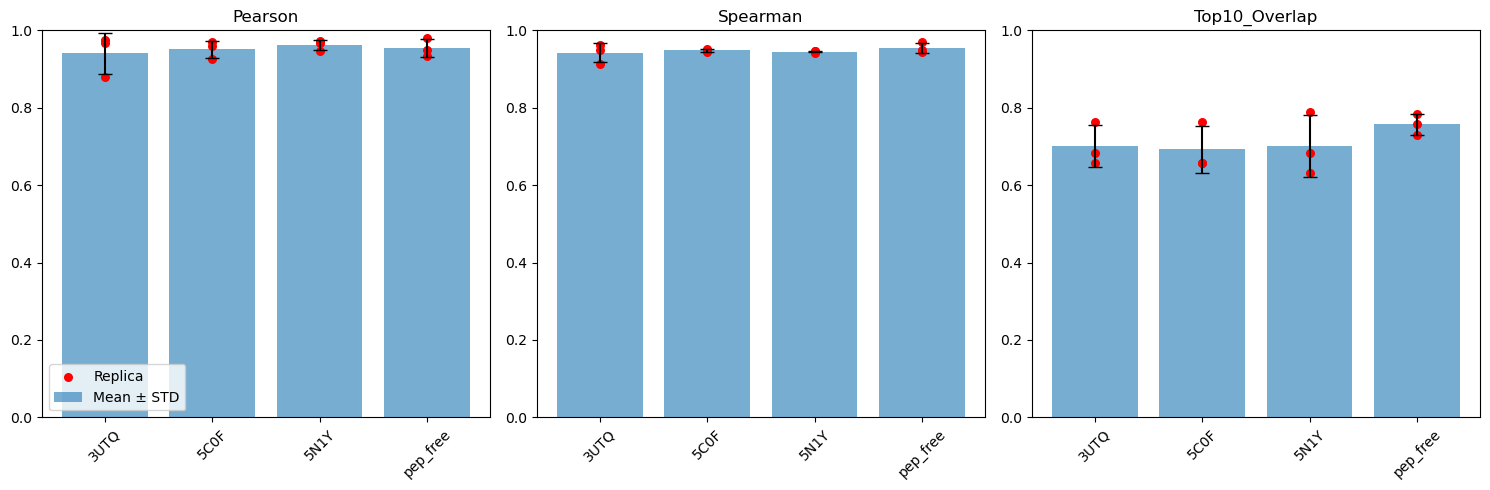

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os

grouped = df_all.groupby("Protein")
proteins = grouped.size().index

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ["Pearson", "Spearman", "Top10_Overlap"]

for i, metric in enumerate(metrics):
    
    means = grouped[metric].mean()
    stds = grouped[metric].std()
    
    # Mean bar
    bars = axes[i].bar(
        proteins,
        means,
        yerr=stds,
        capsize=5,
        alpha=0.6,
        label="Mean ± STD"
    )
    
    # Replica points
    for j, protein in enumerate(proteins):
        values = df_all[df_all["Protein"] == protein][metric]
        axes[i].scatter(
            [j]*len(values),
            values,
            color="red",
            s=30,
            label="Replica" if (i == 0 and j == 0) else ""
        )
    
    axes[i].set_title(metric)
    axes[i].set_xticks(range(len(proteins)))
    axes[i].set_xticklabels(proteins, rotation=45)
    axes[i].set_ylim(0, 1)

# Tek legend (ilk subplot üzerinden)
axes[0].legend()

plt.tight_layout()
fig.savefig("ESSA_summary_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


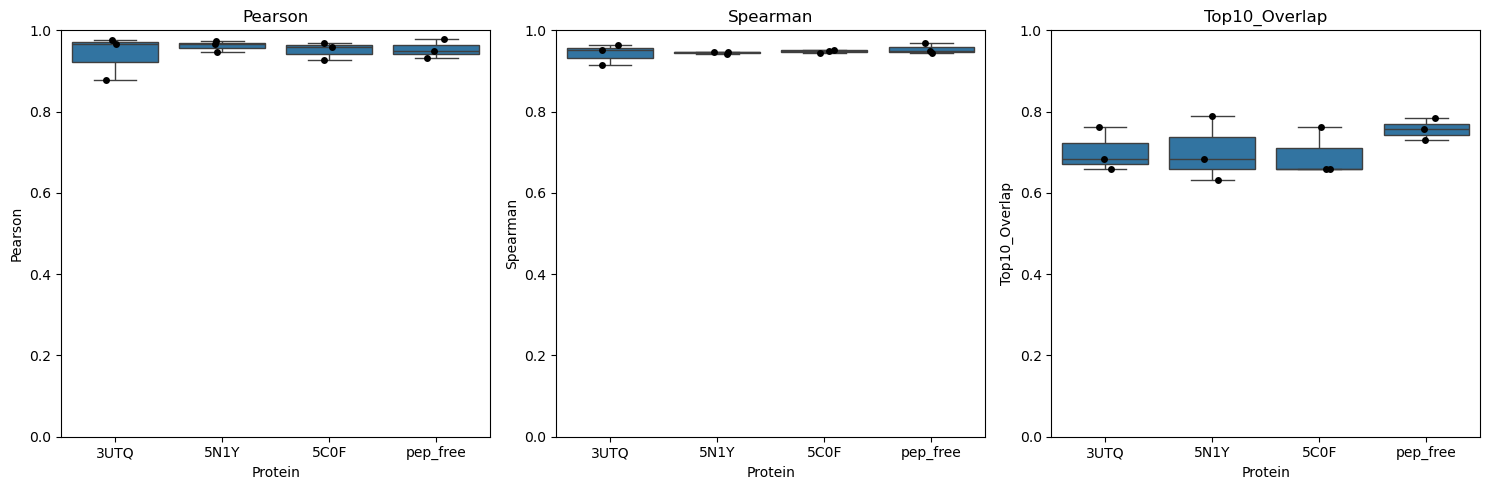

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,5))

metrics = ["Pearson", "Spearman", "Top10_Overlap"]

for i, metric in enumerate(metrics):
    
    sns.boxplot(
        data=df_all,
        x="Protein",
        y=metric,
        ax=axes[i]
    )
    
    sns.stripplot(
        data=df_all,
        x="Protein",
        y=metric,
        ax=axes[i],
        color="black",
        size=5
    )
    
    axes[i].set_ylim(0,1)
    axes[i].set_title(metric)


plt.tight_layout()
fig.savefig("ESSA_summary_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()


# peptid

In [112]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import os

proteins = ["3UTQ", "5C0F", "5N1Y"]
replicas = [0, 1, 2]
fraction = 40

base_gen = "../shuffle_not_allframes"
base_ref = "../../data/palantir_data"

output_dir = "Peptid_analysis"
os.makedirs(output_dir, exist_ok=True)

# === Aynı renkler (MD ve Gen ayrı plotlarda kullanılacak) ===
base_colors = {
    "3UTQ": "tab:blue",
    "5C0F": "tab:orange",
    "5N1Y": "tab:green"
}

# === Combined plot için ayrı renk setleri ===
md_colors_combined = {
    "3UTQ": "navy",
    "5C0F": "darkorange",
    "5N1Y": "darkgreen"
}

gen_colors_combined = {
    "3UTQ": "deepskyblue",
    "5C0F": "orange",
    "5N1Y": "limegreen"
}

def compute_peptide_rmsf(traj):

    idx_align = traj.topology.select("backbone")
    traj.superpose(traj[0], atom_indices=idx_align)

    idx_pep_ca = traj.topology.select("chainid 2 and name CA")

    coords = traj.xyz[:, idx_pep_ca, :]
    mean_coords = coords.mean(axis=0)

    diff = coords - mean_coords
    rmsf_nm = np.sqrt((diff ** 2).sum(axis=2).mean(axis=0))

    return rmsf_nm * 10


positions = np.arange(1, 11)
labels = [f"P{i}" for i in positions]

# ==========================
# 1️⃣ MD Plot (base_colors)
# ==========================

plt.figure(figsize=(8,6))

for protein in proteins:
    first = True
    for rep in replicas:

        xtc_ref = f"{base_ref}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        pdb = f"{base_ref}/{protein}/backbone.pdb"

        ref_traj = md.load(xtc_ref, top=pdb)
        rmsf_ref = compute_peptide_rmsf(ref_traj)

        plt.plot(
            positions,
            rmsf_ref,
            color=base_colors[protein],
            linewidth=2,
            alpha=0.8,
            label=protein if first else None
        )
        first = False

plt.xticks(positions, labels)
plt.ylabel("RMSF (Å)")
plt.xlabel("Peptide Position")
plt.title("MD Peptide RMSF – All Replicas")
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/MD_All_Replicas.png", dpi=300)
plt.close()


# ==========================
# 2️⃣ Generated Plot (base_colors)
# ==========================

plt.figure(figsize=(8,6))

for protein in proteins:
    first = True
    for rep in replicas:

        xtc_gen = f"{base_gen}/{protein}/{protein}_rep_{rep}/fraction_{fraction}/generated_frac_{fraction}.xtc"
        pdb = f"{base_ref}/{protein}/backbone.pdb"

        gen_traj = md.load(xtc_gen, top=pdb)
        rmsf_gen = compute_peptide_rmsf(gen_traj)

        plt.plot(
            positions,
            rmsf_gen,
            color=base_colors[protein],   # aynı renk seti
            linewidth=2,
            alpha=0.8,
            label=protein if first else None
        )
        first = False

plt.xticks(positions, labels)
plt.ylabel("RMSF (Å)")
plt.xlabel("Peptide Position")
plt.title("Generated Peptide RMSF – All Replicas")
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/Generated_All_Replicas.png", dpi=300)
plt.close()


# ==========================
# 3️⃣ Combined Plot (farklı renk aileleri)
# ==========================

plt.figure(figsize=(9,7))

for protein in proteins:

    first_md = True
    first_gen = True

    for rep in replicas:

        pdb = f"{base_ref}/{protein}/backbone.pdb"

        # MD
        xtc_ref = f"{base_ref}/{protein}/{protein}_rep_{rep}_backbone.xtc"
        ref_traj = md.load(xtc_ref, top=pdb)
        rmsf_ref = compute_peptide_rmsf(ref_traj)

        plt.plot(
            positions,
            rmsf_ref,
            color=md_colors_combined[protein],
            linewidth=2,
            alpha=0.9,
            label=f"{protein} MD" if first_md else None
        )
        first_md = False

        # Generated
        xtc_gen = f"{base_gen}/{protein}/{protein}_rep_{rep}/fraction_{fraction}/generated_frac_{fraction}.xtc"
        gen_traj = md.load(xtc_gen, top=pdb)
        rmsf_gen = compute_peptide_rmsf(gen_traj)

        plt.plot(
            positions,
            rmsf_gen,
            color=gen_colors_combined[protein],
            linewidth=2,
            alpha=0.7,
            label=f"{protein} Gen" if first_gen else None
        )
        first_gen = False

plt.xticks(positions, labels)
plt.ylabel("RMSF (Å)")
plt.xlabel("Peptide Position")
plt.title("Peptide RMSF – MD vs Generated")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig(f"{output_dir}/Combined_All_Replicas.png", dpi=300)
plt.close()


